In [1]:
!cp "/content/drive/MyDrive/AffectNet data/balance_affectNet.h5" affectnet.h5

In [2]:
import os
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

IMAGE_SIZE = 128

img_size = (IMAGE_SIZE, IMAGE_SIZE)
num_classes = 3
batch_size = 32

hf = h5py.File('affectnet.h5', 'r')
faces = hf['images'][:]
hf.close()

faces = [cv2.cvtColor(cv2.resize(face, img_size), cv2.COLOR_BGR2RGB) for face in faces]
faces = np.array(faces)

print("images.shape ", faces.shape)

images.shape  (52871, 128, 128, 3)


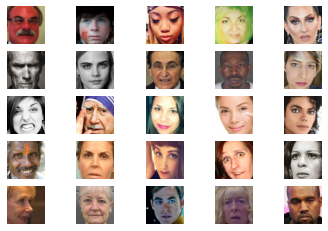

In [3]:
def plot_faces(faces, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(faces[i].astype('uint8'))

plot_faces(faces, 5)

# Define PG GAN Model

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

## Define helper (custom) layer

In [5]:
# weighted sum output
class WeightedSum(Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = backend.variable(alpha, name='ws_alpha')

	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

In [6]:
# mini-batch standard deviation layer
class MinibatchStdev(Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(MinibatchStdev, self).__init__(**kwargs)

	# perform the operation
	def call(self, inputs):
		# calculate the mean value for each pixel across channels
		mean = backend.mean(inputs, axis=0, keepdims=True)
		# calculate the squared differences between pixel values and mean
		squ_diffs = backend.square(inputs - mean)
		# calculate the average of the squared differences (variance)
		mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
		# add a small value to avoid a blow-up when we calculate stdev
		mean_sq_diff += 1e-8
		# square root of the variance (stdev)
		stdev = backend.sqrt(mean_sq_diff)
		# calculate the mean standard deviation across each pixel coord
		mean_pix = backend.mean(stdev, keepdims=True)
		# scale this up to be the size of one input feature map for each sample
		shape = backend.shape(inputs)
		output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
		# concatenate with the output
		combined = backend.concatenate([inputs, output], axis=-1)
		return combined

	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		# create a copy of the input shape as a list
		input_shape = list(input_shape)
		# add one to the channel dimension (assume channels-last)
		input_shape[-1] += 1
		# convert list to a tuple
		return tuple(input_shape)

In [7]:
# pixel-wise feature vector normalization layer
class PixelNormalization(Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(PixelNormalization, self).__init__(**kwargs)

	# perform the operation
	def call(self, inputs):
		# calculate square pixel values
		values = inputs**2.0
		# calculate the mean pixel values
		mean_values = backend.mean(values, axis=-1, keepdims=True)
		# ensure the mean is not zero
		mean_values += 1.0e-8
		# calculate the sqrt of the mean squared value (L2 norm)
		l2 = backend.sqrt(mean_values)
		# normalize values by the l2 norm
		normalized = inputs / l2
		return normalized

	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		return input_shape

# Implement PG GAN

In [8]:
# The target value will be 1 for real images and -1 for fake images.

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [33]:
# add a discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = max_norm(1.0)
    # get shape of existing model
    in_shape = list(old_model.input.shape)
    
    print("in_shape: ", in_shape)

    # define new input shape as double the size
    input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
    in_image = Input(shape=input_shape)
    # define new input processing layer
    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # define new block
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
    block_new = d
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    # define straight-through model
    model1 = Model(in_image, d)
    # compile model
    model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
    # downsample the new larger image
    downsample = AveragePooling2D()(in_image)
    # connect old input processing to downsampled new input
    block_old = old_model.layers[1](downsample)
    block_old = old_model.layers[2](block_old)
    # fade in output of old model input layer with new input
    d = WeightedSum()([block_old, block_new])
    # skip the input, 1x1 and activation for the old model
    for i in range(n_input_layers, len(old_model.layers)):
        d = old_model.layers[i](d)
    # define straight-through model
    model2 = Model(in_image, d)
    # compile model
    model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
    return [model1, model2]

# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = max_norm(1.0)
    model_list = list()
    # base model input
    in_image = Input(shape=input_shape)
    # conv 1x1
    d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # conv 3x3 (output block)
    d = MinibatchStdev()(d)
    d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # conv 4x4
    d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # dense output layer
    d = Flatten()(d)
    out_class = Dense(1)(d)
    # define model
    model = Model(in_image, out_class)
    # compile model
    model.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    print("[INFO]: ")
    model.summary()

    # store model
    model_list.append([model, model])
    # create submodels
    for i in range(1, n_blocks):
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        # create new model for next resolution
        models = add_discriminator_block(old_model)
        # store model
        model_list.append(models)
    return model_list

In [10]:
# add a generator block
def add_generator_block(old_model):
	
    # weight initialization
    init = RandomNormal(stddev=0.02)

    # weight constraint
    const = max_norm(1.0)

    # get the end of the last block
    block_end = old_model.layers[-2].output

    # upsample, and define new block
    upsampling = UpSampling2D()(block_end)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    # add new output layer
    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)

    # define model
    model1 = Model(old_model.input, out_image)

    # get the output layer from old model
    out_old = old_model.layers[-1]

    # connect the upsampling to the old output layer
    out_image2 = out_old(upsampling)

    # define new output image as the weighted sum of the old and new models
    merged = WeightedSum()([out_image2, out_image])

    # define model
    model2 = Model(old_model.input, merged)

    return [model1, model2]

# define generator models
def define_generator(latent_dim, n_blocks, in_dim=4):
	
    # weight initialization
    init = RandomNormal(stddev=0.02)

    # weight constraint
    const = max_norm(1.0)
    model_list = list()

    # base model latent input
    in_latent = Input(shape=(latent_dim,))

    # linear scale up to activation maps
    g  = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
    g = Reshape((in_dim, in_dim, 128))(g)

    # conv 4x4, input block
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    # conv 3x3
    g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
    g = PixelNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    # conv 1x1, output block
    out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)

    # define model
    model = Model(in_latent, out_image)

    # store model
    print("[INFO]: ")
    model.summary()

    model_list.append([model, model])
	
    # create submodels
    for i in range(1, n_blocks):
        # get prior model without the fade-on
        old_model = model_list[i - 1][0]
        # create new model for next resolution
        models = add_generator_block(old_model)
        # store model
        model_list.append(models)

    return model_list

In [11]:
def define_composite(discriminators, generators):
    model_list = list()
    # create composite models
    for i in range(len(discriminators)):
        
        g_models, d_models = generators[i], discriminators[i]
        
        # straight-through model
        d_models[0].trainable = False
        model1 = Sequential()
        model1.add(g_models[0])
        model1.add(d_models[0])
        model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
        
        # fade-in model
        d_models[1].trainable = False
        model2 = Sequential()
        model2.add(g_models[1])
        model2.add(d_models[1])
        model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
        
        # store
        model_list.append([model1, model2])
    return model_list

# Traning 

In [12]:
def load_real_samples(X):

	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [13]:
# select real samples
def generate_real_samples(dataset, n_samples):

    ix = np.random.randint(0, dataset.shape[0], n_samples)

    # select images
    X = dataset[ix]
    y = np.ones((n_samples, 1))

    return X, y

In [14]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    
    x_input = np.random.randn(latent_dim * n_samples)
    
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [15]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):

	x_input = generate_latent_points(latent_dim, n_samples)
	
    # predict outputs
	X = generator.predict(x_input)
	
    # create class labels
	y = -np.ones((n_samples, 1))
	return X, y

In [16]:
# update the alpha value on each instance of WeightedSum
def update_fadein(models, step, n_steps):
	
    # calculate current alpha (linear from 0 to 1)
	alpha = step / float(n_steps - 1)

	# update the alpha for each model
	for model in models:
		for layer in model.layers:
			if isinstance(layer, WeightedSum):
				backend.set_value(layer.alpha, alpha)

In [17]:
# train a generator and discriminator
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein=False):
    
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_steps):
        
        # update alpha for all WeightedSum layers when fading in new blocks
        if fadein:
            update_fadein([g_model, d_model, gan_model], i, n_steps)
        
        # prepare real and fake samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        # update discriminator model
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        
        # update the generator via the discriminator's error
        z_input = generate_latent_points(latent_dim, n_batch)
        y_real2 = ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(z_input, y_real2)

        # summarize on every epoch
        if (i + 1) % bat_per_epo == 0:
            print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

In [18]:
# scale images to preferred size
def scale_dataset(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [19]:
# generate samples and save as a plot and save the model
def summarize_performance(status, g_model, latent_dim, n_samples=25):
	# devise name
	gen_shape = g_model.output_shape
	name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
	# generate images
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# normalize pixel values to the range [0,1]
	X = (X - X.min()) / (X.max() - X.min())
	# plot real images
	square = int(sqrt(n_samples))
	for i in range(n_samples):
		pyplot.subplot(square, square, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X[i])
	# save plot to file
	filename1 = 'plot_%s.png' % (name)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%s.h5' % (name)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [20]:
# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
	# fit the baseline model
	g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
	# scale dataset to appropriate size
	gen_shape = g_normal.output_shape
	scaled_data = scale_dataset(dataset, gen_shape[1:])
	print('Scaled Data', scaled_data.shape)
	# train normal or straight-through models
	train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0])
	summarize_performance('tuned', g_normal, latent_dim)
	# process each level of growth
	for i in range(1, len(g_models)):
		# retrieve models for this level of growth
		[g_normal, g_fadein] = g_models[i]
		[d_normal, d_fadein] = d_models[i]
		[gan_normal, gan_fadein] = gan_models[i]
		# scale dataset to appropriate size
		gen_shape = g_normal.output_shape
		scaled_data = scale_dataset(dataset, gen_shape[1:])
		print('Scaled Data', scaled_data.shape)
		# train fade-in models for next level of growth
		train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True)
		summarize_performance('faded', g_fadein, latent_dim)
		# train normal or straight-through models
		train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i])
		summarize_performance('tuned', g_normal, latent_dim)

In [ ]:
# example of progressive growing gan on celebrity faces dataset
from math import sqrt
from numpy import load
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

from skimage.transform import resize
from keras.optimizers import Adam
from keras.constraints import max_norm
from keras.initializers import RandomNormal
from keras import backend

# number of growth phases, e.g. 6 == [4, 8, 16, 32, 64, 128]
n_blocks = 6
# size of the latent space
latent_dim = 100
# define models
d_models = define_discriminator(n_blocks)
# define models
g_models = define_generator(latent_dim, n_blocks)
# define composite models
gan_models = define_composite(d_models, g_models)
# load image data
dataset = load_real_samples(faces)
print('Loaded', dataset.shape)
# train model
n_batch = [16, 16, 16, 8, 4, 4]
# 10 epochs == 500K images per training phase
n_epochs = [5, 8, 8, 10, 10, 10]
train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_epochs, n_batch)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4, 4, 3)]         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
minibatch_stdev_4 (Minibatch (None, 4, 4, 129)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 128)         148736    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)         2622